##### Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
#from scipy.misc import imread,imresize
#from scipy.misc import imresize
from skimage.io import imread
from skimage.transform import resize
import datetime
import os

import warnings
warnings.filterwarnings("ignore")

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)
print(tf.__version__)

In [3]:
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
%matplotlib inline

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
#setting experimental batch size of 20
batch_size = 20
##Setting image dimension =120x120
xdim, ydim = 120, 120
img_idx_sel = range(0,25,2)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize

def generator(source_path, folder_list, batch_size, img_idx_sel, xdim, ydim):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_idx_sel  # creating a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = ydim, xdim  # note the change in order of ydim and xdim
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size  # calculate the number of batches based on the total number of folders

        for batch in range(num_batches):  # iterate over the batches
            batch_data = np.zeros((batch_size, x, y, z, 3))  # initialize batch data
            batch_labels = np.zeros((batch_size, 5))  # initialize batch labels
            for folder in range(batch_size):  # iterate over the batch
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])  # read all the images in the folder
                for idx, item in enumerate(img_idx):  # Iterate over the frames/images of a folder to read them in
                    image = imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item]).astype(np.float32)

                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px // 2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px // 2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    resized_im = resize(image, (y, z))  # resize the image

                    # normalise and feed in the image
                    batch_data[folder, idx, :, :, 0] = resized_im[:, :, 0] / 255
                    batch_data[folder, idx, :, :, 1] = resized_im[:, :, 1] / 255
                    batch_data[folder, idx, :, :, 2] = resized_im[:, :, 2] / 255

                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels  # yield the batch data and labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10    ### Setting initial 20 epochs to test
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#Input Shape
input_shape = (len(img_idx_sel), xdim, ydim, 3)

## Model
Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

##### 

##### Model 1
Simple model with CONV3D, MaxPooling3D, BatchNormalization and Dense Layers

In [11]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

##### Compile

##### A function for Compiling the models - htat can be reused for all models

In [10]:
def model_compile():
    optimiser = optimizers.Adam(0.01)#write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())

Let us create the train_generator and the val_generator which will be used in .fit_generator.

##### A function to generate train generator- that would be reused for each model

In [12]:
from datetime import datetime
def train_val_gen():
    train_generator = generator(train_path, train_doc, batch_size,img_idx_sel, xdim, ydim)
    val_generator = generator(val_path, val_doc, batch_size,img_idx_sel, xdim, ydim)
    model_name = 'model_init_' + datetime.now().strftime('%Y-%m-%d_%H_%M_%S') + '/'
    if not os.path.exists(model_name):
        os.mkdir(model_name)
            
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
    
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
    callbacks_list = [checkpoint, LR]
    return train_generator, val_generator, callbacks_list

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Write a function that can be reused for each model

In [13]:
def stps_pr_epoch():
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1
    
    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return steps_per_epoch, validation_steps

##### Fit the model
Write a function to fit the models

In [14]:
def model_fit():
    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, initial_epoch=0)
    return history

##### Plot
Write a function to plot the accuracy and loss of model

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
def model_plot(model_n):
    plt.figure(figsize=(20,5))
    ax1 = plt.subplot(121)
    ax1 = plt.plot(model_n.history['loss'])
    ax1 = plt.plot(model_n.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'])

    ax2 = plt.subplot(122)
    ax2 = plt.plot(model_n.history['categorical_accuracy'])
    ax2 = plt.plot(model_n.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('categorical_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])

In [15]:
train_generator, val_generator, callbacks_list = train_val_gen()
steps_per_epoch, validation_steps = stps_pr_epoch()

In [129]:
model_compile()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_14 (Conv3D)              │ (None, 11, 118, 118,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_14 (MaxPooling3D) │ (None, 5, 59, 59, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_15 (Conv3D)              │ (None, 3, 57, 57, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_15 (MaxPooling3D) │ (None, 1, 28, 28, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 50176)          │       200,704 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,681,989 (25.49 MB)

 Trainable params: 6,581,637 (25.11 MB)

 Non-trainable params: 100,352 (392.00 KB)

None


In [130]:
m1=model_fit()

Source path =  Project_data/train ; batch size = 20
Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3257 - loss: 34.9106Source path =  Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 1079.27307, saving model to model_init_2024-04-08_11_24_44/model-00001-21.43027-0.35000-1079.27307-0.23000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - categorical_accuracy: 0.3264 - loss: 34.5254 - val_categorical_accuracy: 0.2300 - val_loss: 1079.2731 - learning_rate: 0.0100
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3325 - loss: 1.5369
Epoch 2: val_loss improved from 1079.27307 to 589.16583, saving model to model_init_2024-04-08_11_24_44/model-00002-1.63717-0.30588-589.16583-0.23000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - categorical_accuracy: 0.3317 - loss: 1.5397 - val_categorical_accuracy: 0.2300 - val_loss: 589.1658 - learning_rate: 0.0100
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accu

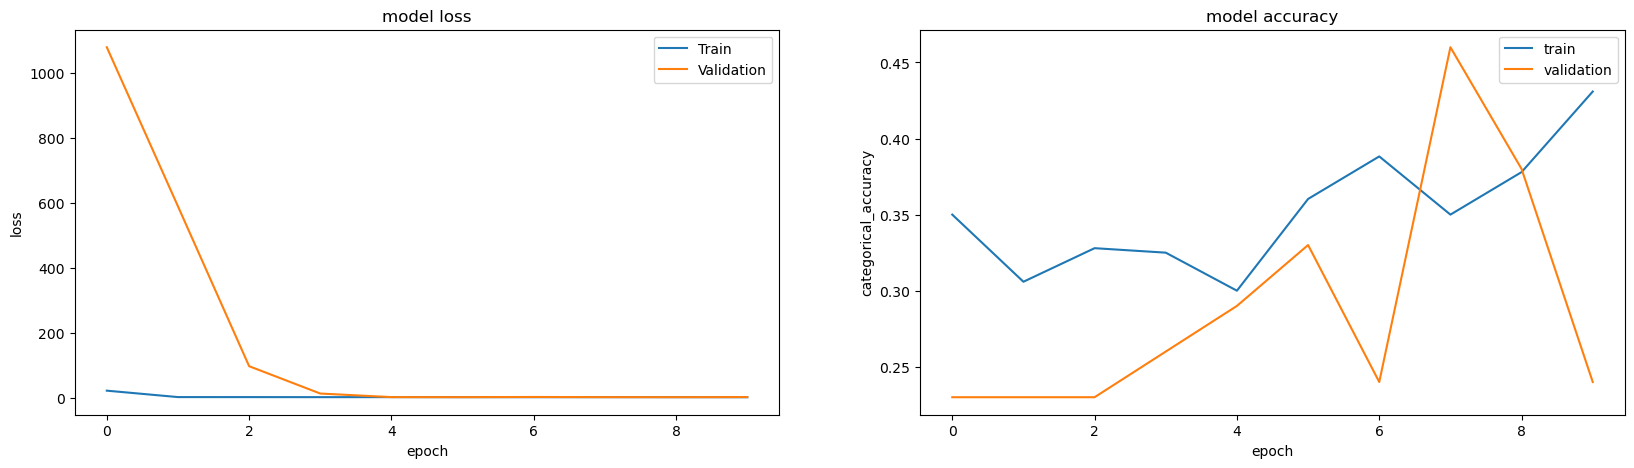

In [131]:
model_plot(m1)

##### Model 2 
TimeDistributed with Conv2D, BatchNormalization, Dropout, Flatten

In [136]:
#Second Model
model = Sequential()
model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

         
model.add(TimeDistributed(Conv2D(64, (3, 3),activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(128, (3, 3),activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
#model.summary()

In [137]:
train_generator, val_generator, callbacks_list = train_val_gen()
steps_per_epoch, validation_steps = stps_pr_epoch()

In [138]:
model_compile()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_16             │ (None, 13, 118, 118,   │         3,584 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 13, 59, 59,     │             0 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 13, 59, 59,     │           512 │
│ (BatchNormalization)            │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 13, 57, 57, 64) │        73,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 13, 57, 57, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 13, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 13, 28, 28, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 13, 26, 26,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 13, 26, 26,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 13, 13, 13,     │             0 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 281216)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │    35,995,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,148,933 (137.90 MB)

 Trainable params: 36,148,293 (137.89 MB)

 Non-trainable params: 640 (2.50 KB)

None


In [139]:
m2=model_fit()

Source path =  Project_data/train ; batch size = 20
Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 50s/step - categorical_accuracy: 0.3058 - loss: 553.2433 Source path =  Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 751.49451, saving model to model_init_2024-04-08_11_42_17/model-00001-389.58911-0.33676-751.49451-0.20000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1759s 51s/step - categorical_accuracy: 0.3067 - loss: 548.5674 - val_categorical_accuracy: 0.2000 - val_loss: 751.4945 - learning_rate: 0.0100
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 54s/step - categorical_accuracy: 0.3452 - loss: 97.5112 
Epoch 2: val_loss improved from 751.49451 to 337.60196, saving model to model_init_2024-04-08_11_42_17/model-00002-71.40261-0.30735-337.60196-0.18000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1832s 54s/step - categorical_accuracy: 0.3441 - loss: 96.7653 - val_categorical_accuracy: 0.1800 - val_loss: 337.6020 - learning_rate: 0.0100
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 47s/step - cat

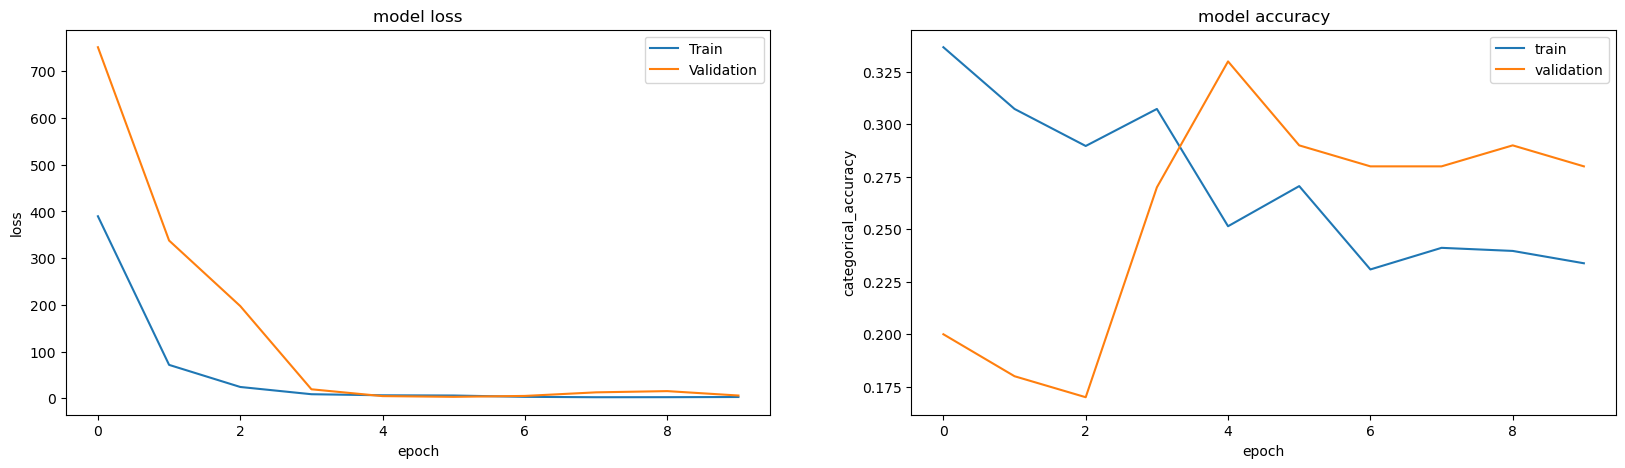

In [141]:
model_plot(m2)

In [142]:
#Reduce Epoch size to 5 due to limitation in computational power

In [16]:
num_epochs = 5

##### Model 3 :LSTM
TimeDistributed with Conv2D, BatchNormalization, Dropout, Flatten

In [147]:
model = Sequential()
model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2,2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(128))
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

In [148]:
train_generator, val_generator, callbacks_list = train_val_gen()
steps_per_epoch, validation_steps = stps_pr_epoch()

In [150]:
model_compile()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_39             │ (None, 13, 118, 118,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 13, 118, 118,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_40             │ (None, 13, 59, 59, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_41             │ (None, 13, 59, 59, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_42             │ (None, 13, 59, 59, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_43             │ (None, 13, 29, 29, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_44             │ (None, 13, 29, 29, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_45             │ (None, 13, 29, 29, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_46             │ (None, 13, 14, 14, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_47             │ (None, 13, 14, 14,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_48             │ (None, 13, 14, 14,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_49             │ (None, 13, 7, 7, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_50             │ (None, 13, 7, 7, 256)  │       295,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_51             │ (None, 13, 7, 7, 256)  │         1,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_52             │ (None, 13, 3, 3, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_53             │ (None, 13, 2304)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     1,245,69

 Total params: 1,657,445 (6.32 MB)

 Trainable params: 1,656,453 (6.32 MB)

 Non-trainable params: 992 (3.88 KB)

None


In [151]:
m3=model_fit()

Source path =  Project_data/train ; batch size = 20
Epoch 1/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.2396 - loss: 1.7248Source path =  Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 1.59773, saving model to model_init_2024-04-08_16_19_12/model-00001-1.62431-0.27206-1.59773-0.21000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 213s 6s/step - categorical_accuracy: 0.2405 - loss: 1.7219 - val_categorical_accuracy: 0.2100 - val_loss: 1.5977 - learning_rate: 0.0100
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.3708 - loss: 1.3865
Epoch 2: val_loss improved from 1.59773 to 1.53581, saving model to model_init_2024-04-08_16_19_12/model-00002-1.39370-0.36324-1.53581-0.31000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 189s 6s/step - categorical_accuracy: 0.3706 - loss: 1.3867 - val_categorical_accuracy: 0.3100 - val_loss: 1.5358 - learning_rate: 0.0100
Epoch 3/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.3586 - loss: 1

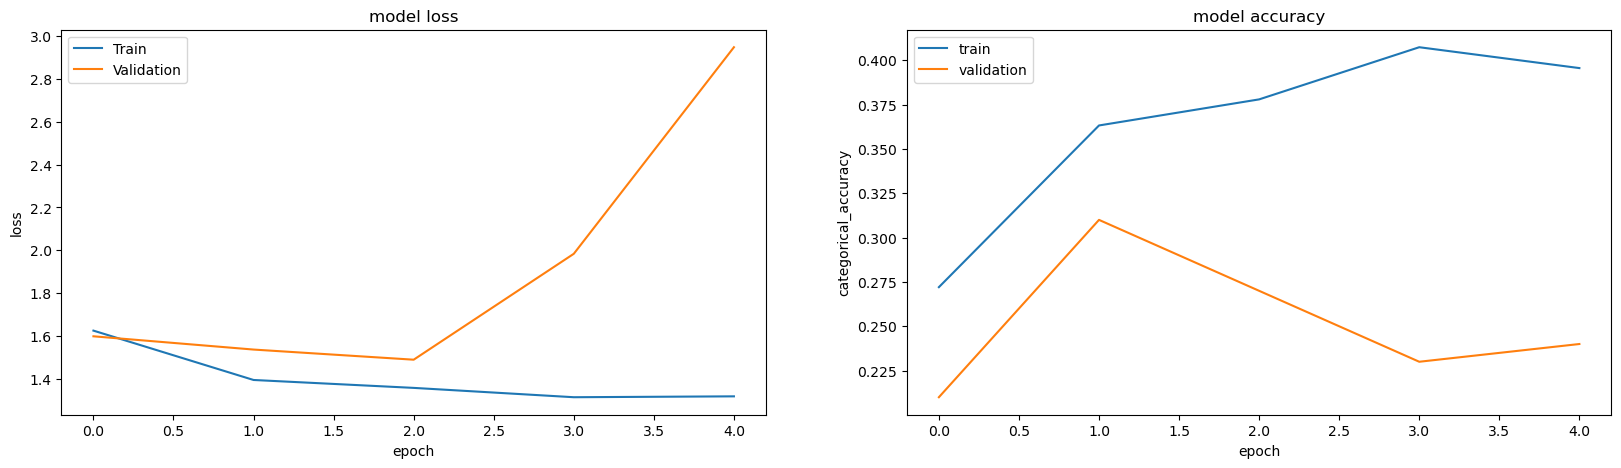

In [152]:
model_plot(m3)

##### Model 4: GRU
TimeDistributed + Conv2D, BatchNormalization, BatchNormalization,Flatten, Dropout with GRU

In [153]:
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'),input_shape= input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(BatchNormalization((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(256))
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

In [154]:
train_generator, val_generator, callbacks_list = train_val_gen()
steps_per_epoch, validation_steps = stps_pr_epoch()

In [155]:
model_compile()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_54             │ (None, 13, 118, 118,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_55             │ (None, 13, 118, 118,   │           128 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_56             │ (None, 13, 59, 59, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_57             │ (None, 13, 59, 59, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_58             │ (None, 13, 59, 59, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_59             │ (None, 13, 29, 29, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_60             │ (None, 13, 29, 29,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_61             │ (None, 13, 29, 29,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_62             │ (None, 13, 14, 14,     │             0 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_63             │ (None, 13, 14, 14,     │       295,168 │
│ (TimeDistributed)               │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_64             │ (None, 13, 14, 14,     │         1,024 │
│ (TimeDistributed)               │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_65             │ (None, 13, 7, 7, 256)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_66             │ (None, 13, 12544)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 256)            │     9,831,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 10,289,349 (39.25 MB)

 Trainable params: 10,288,389 (39.25 MB)

 Non-trainable params: 960 (3.75 KB)

None


In [156]:
m4 = model_fit()

Source path =  Project_data/train ; batch size = 20
Epoch 1/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.2792 - loss: 2.1986 Source path =  Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 1.42336, saving model to model_init_2024-04-08_16_37_48/model-00001-1.86008-0.30588-1.42336-0.39000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 424s 12s/step - categorical_accuracy: 0.2800 - loss: 2.1889 - val_categorical_accuracy: 0.3900 - val_loss: 1.4234 - learning_rate: 0.0100
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - categorical_accuracy: 0.4239 - loss: 1.3628 
Epoch 2: val_loss improved from 1.42336 to 1.18208, saving model to model_init_2024-04-08_16_37_48/model-00002-1.32166-0.44559-1.18208-0.53000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 355s 10s/step - categorical_accuracy: 0.4246 - loss: 1.3616 - val_categorical_accuracy: 0.5300 - val_loss: 1.1821 - learning_rate: 0.0100
Epoch 3/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - categorical_accuracy: 0.4894 - 

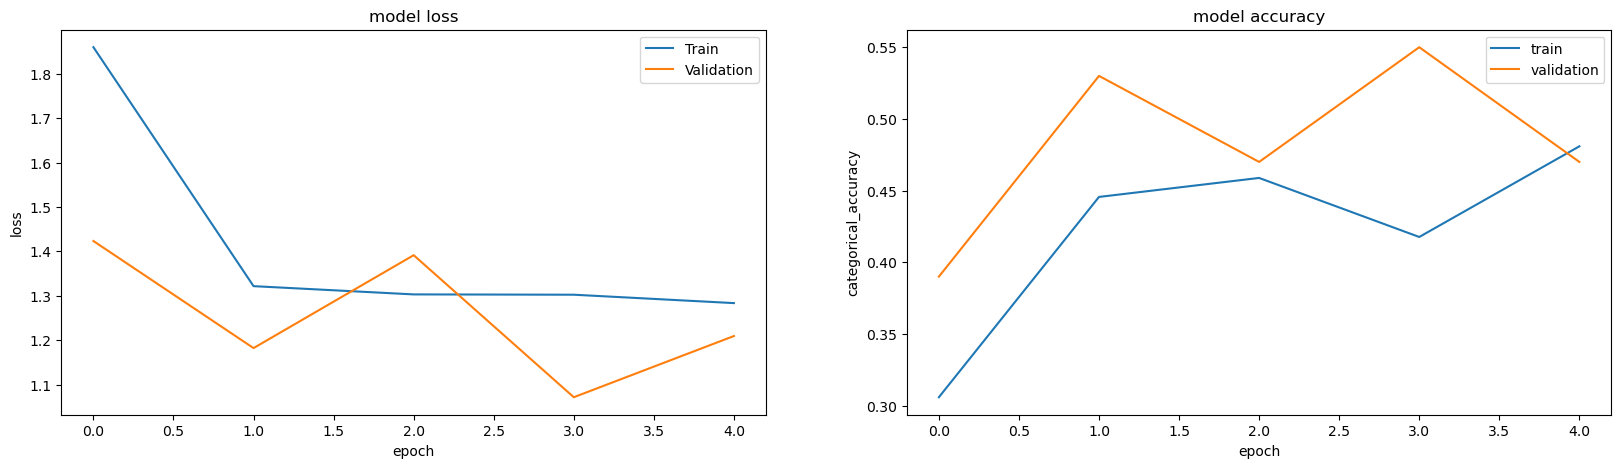

In [157]:
model_plot(m4)

##### Model 5 : Add more layers to the earlier LSTM model (Model 3)

In [17]:
model = Sequential()
model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2,2))))

model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

#model.add(TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(LSTM(128))
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

In [18]:
train_generator, val_generator, callbacks_list = train_val_gen()
steps_per_epoch, validation_steps = stps_pr_epoch()

In [19]:
model_compile()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 13, 118, 118,   │         1,792 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 118, 118,   │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 13, 59, 59, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 13, 59, 59,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 13, 59, 59,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 13, 29, 29,     │             0 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 13, 29, 29,     │       147,584 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 13, 29, 29,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 13, 14, 14,     │             0 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 13, 14, 14, 64) │        73,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 13, 14, 14, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 13, 7, 7, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 13, 7, 7, 128)  │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 13, 7, 7, 128)  │           512 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 13, 3, 3, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 13, 1152)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       655,87

 Total params: 1,045,957 (3.99 MB)

 Trainable params: 1,044,933 (3.99 MB)

 Non-trainable params: 1,024 (4.00 KB)

None


In [20]:
m5 = model_fit()

Source path =  Project_data/train ; batch size = 20
Epoch 1/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - categorical_accuracy: 0.2718 - loss: 1.6989 Source path =  Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 1.75855, saving model to model_init_2024-04-08_21_33_12/model-00001-1.54823-0.31912-1.75855-0.25000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 990s 29s/step - categorical_accuracy: 0.2731 - loss: 1.6946 - val_categorical_accuracy: 0.2500 - val_loss: 1.7586 - learning_rate: 0.0100
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - categorical_accuracy: 0.4406 - loss: 1.2626 
Epoch 2: val_loss improved from 1.75855 to 1.54348, saving model to model_init_2024-04-08_21_33_12/model-00002-1.27511-0.44265-1.54348-0.26000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 992s 29s/step - categorical_accuracy: 0.4407 - loss: 1.2630 - val_categorical_accuracy: 0.2600 - val_loss: 1.5435 - learning_rate: 0.0100
Epoch 3/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - categorical_accuracy: 0.4784 - 

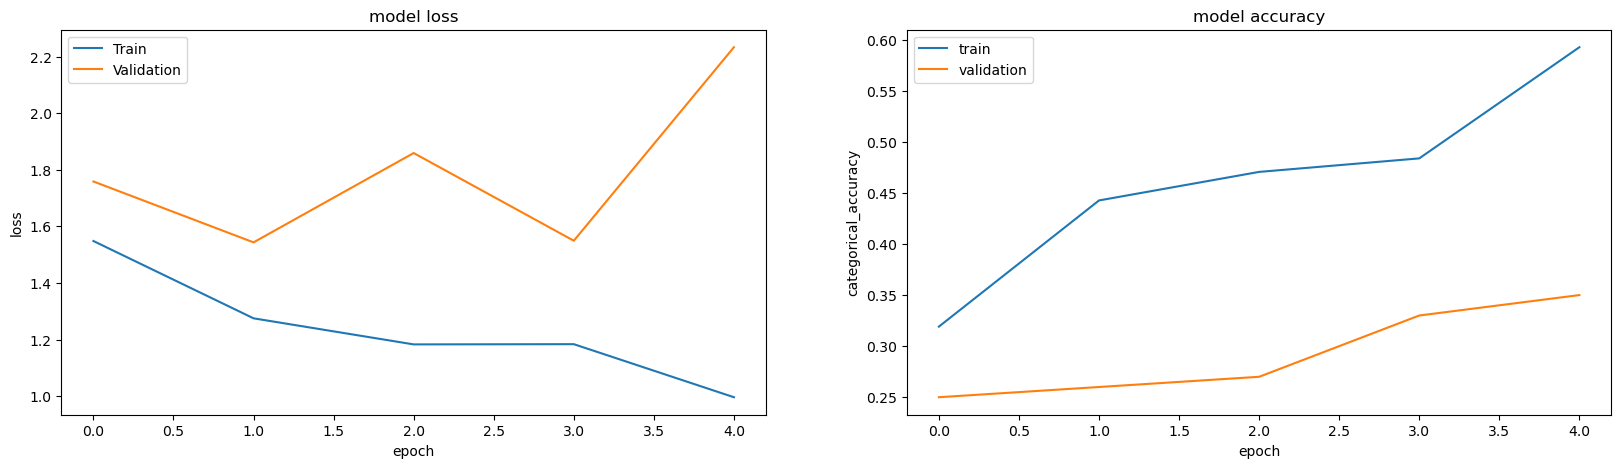

In [21]:
model_plot(m5)

##### Use transfer Learning

In [23]:
from keras.applications import mobilenet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape= input_shape))

model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.25))


model.add(GRU(256))
model.add(Dropout(0.5))

model.add(Dense(128,activation='relu'))
model.add(Dropout(.25))

model.add(Dense(5, activation='softmax'))

In [24]:
train_generator, val_generator, callbacks_list = train_val_gen()
steps_per_epoch, validation_steps = stps_pr_epoch()

In [26]:
model_compile()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_15             │ ?                      │     3,228,864 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

None


In [27]:
m6 = model_fit()

Source path =  Project_data/train ; batch size = 20
Epoch 1/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.2771 - loss: 2.0768Source path =  Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 1.59229, saving model to model_init_2024-04-08_23_02_13/model-00001-1.80222-0.30441-1.59229-0.32000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 329s 7s/step - categorical_accuracy: 0.2779 - loss: 2.0690 - val_categorical_accuracy: 0.3200 - val_loss: 1.5923 - learning_rate: 0.0100
Epoch 2/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.3350 - loss: 1.4224
Epoch 2: val_loss improved from 1.59229 to 1.38436, saving model to model_init_2024-04-08_23_02_13/model-00002-1.34982-0.37500-1.38436-0.32000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 223s 7s/step - categorical_accuracy: 0.3362 - loss: 1.4203 - val_categorical_accuracy: 0.3200 - val_loss: 1.3844 - learning_rate: 0.0100
Epoch 3/5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.4529 - loss: 1

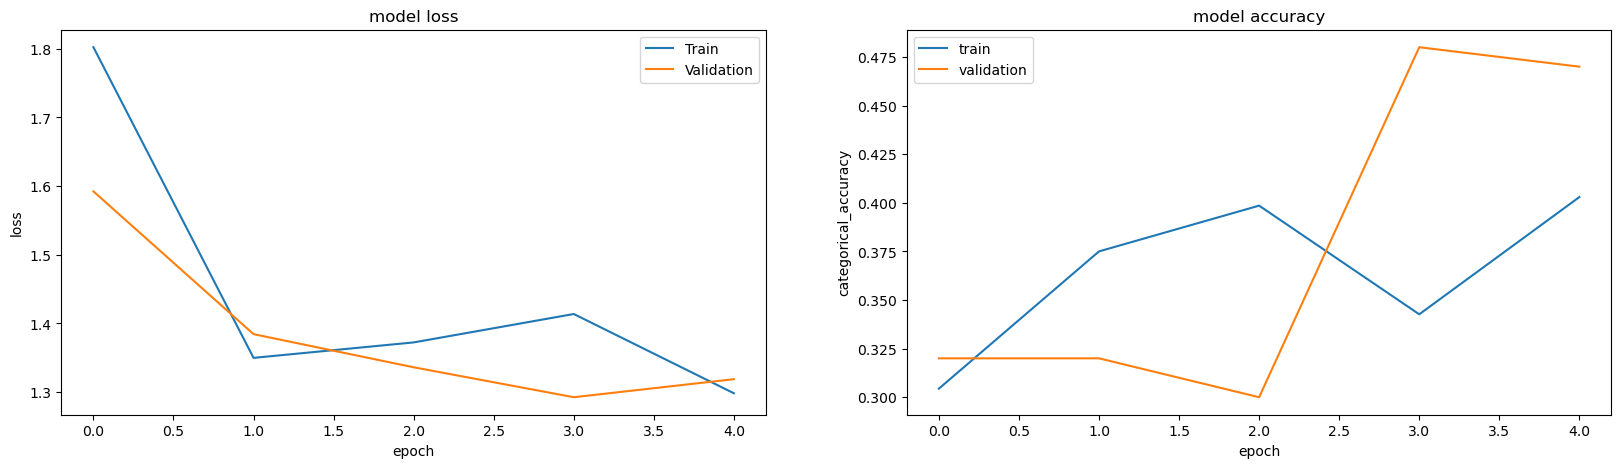

In [28]:
model_plot(m6)

##### I would have built couple of more models as follows- but unable to do so due to computational resource constaraints

Model 7 would have been transfer learning with LSTm
Model 8 would ahve been GRU with more layers

##### Final conlusion 

I would select the Model 4- which is using GRU as my final model- as that gives the best accuracy
